# Problem Definition

Use historical boxscores to predict an NBA player's Assists Per Second (APS) in a single game. In conjunction with the predicted NBA player's Seconds Played (SP) will be used to predict the total assists of a player in a single game.

### Usage

- The final assist projection will be used along other stat projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

## Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/.virtualenvs/nbavenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Assists Per Second (APS).

- Historical APS
    - Season averages
    - Recent performances
    - Home vs. Away
    - Start vs. Bench
    - Rest


- Position


- Defense
    - Opponent APS Allowed
        - Starters vs. Bench Players
        - By position
    - Vegas implied total points


- Injuries
    - Player APS by starting lineup/ active high assist players


# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

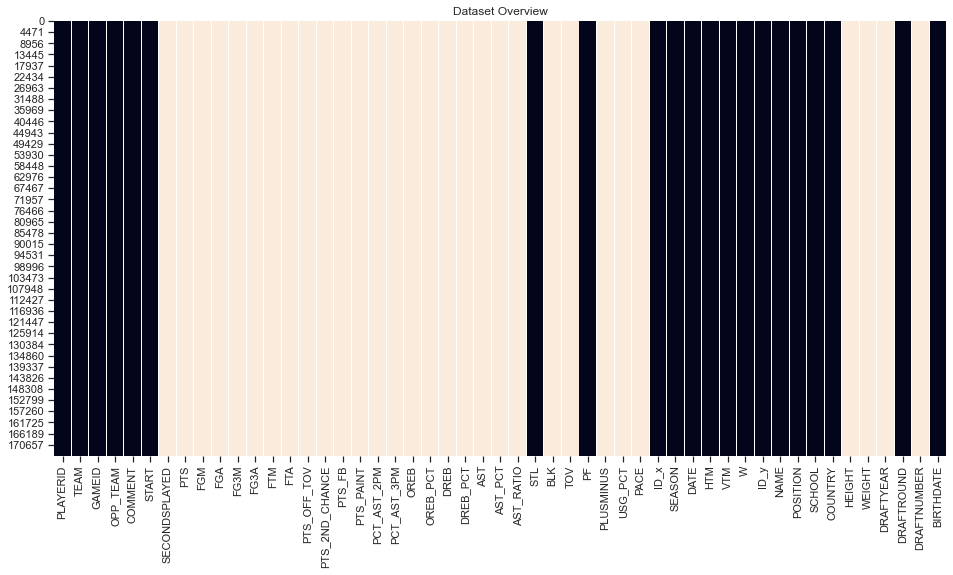

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $APS$.

In [4]:
y = 'Y'
boxscores[y] = boxscores['AST']/boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

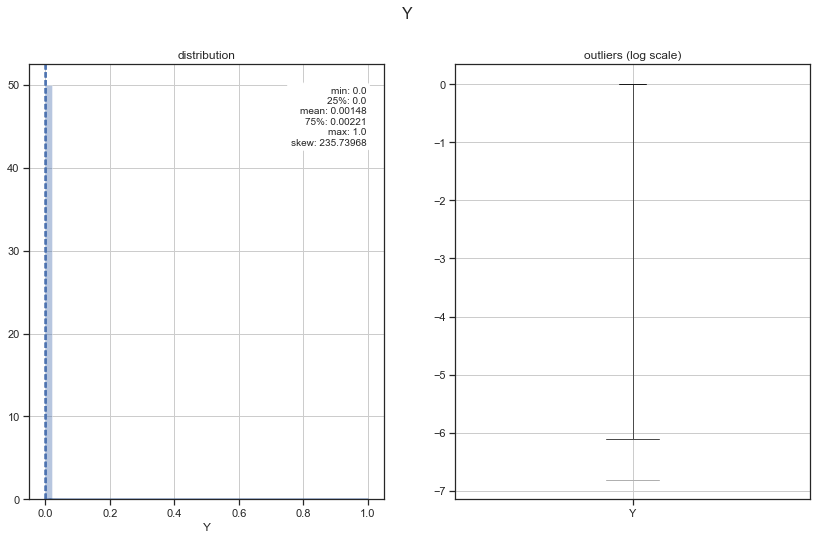

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Yikes.

There is clearly an abundance of outliers on the right side of the distribution.

My first guess of the cause of the plethora of outliers is that those outliers come from boxscores in which the player played very few seconds. For example, if a player played for 6 seconds, and dished 1 assist, his APS would be 0.167. That would be an outlier in our distribtion.

Below shows the APS distribution across different playing times.

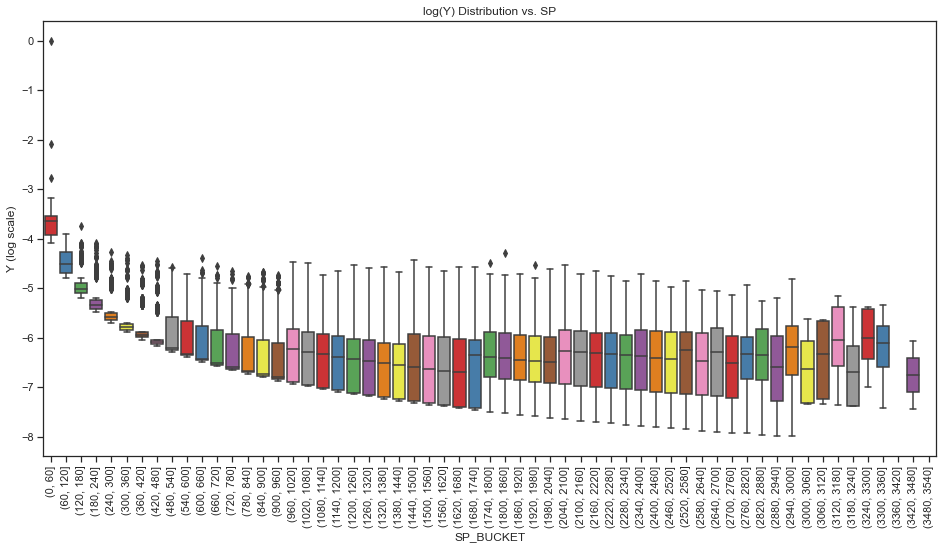

In [6]:
sp_max = boxscores['SECONDSPLAYED'].max()
max_bucket = int(60 * round(float(sp_max)/60))
buckets = [i for i in range(0, max_bucket, 60)]

temp = boxscores[[y, 'SECONDSPLAYED']]
temp['Y (log scale)'] = temp[y].apply(lambda x: np.log(x) if x > 0 else np.nan)
temp['SP_BUCKET'] = pd.cut(temp['SECONDSPLAYED'], buckets)

ax = sns.boxplot(x="SP_BUCKET", y="Y (log scale)", data=temp, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('log(Y) Distribution vs. SP')
plt.show()
plt.close()

It seems as though the outliers are coming from the (0, 60] seconds played bucket. Let's remove those values from our set of outcomes, and replot the distributions.

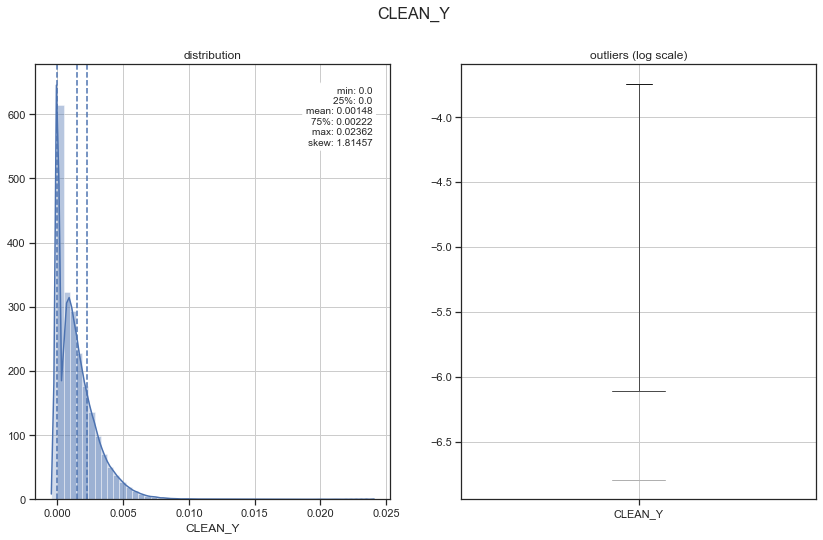

In [7]:
sp_threshold = 60

clean_y = 'CLEAN_Y'
boxscores[clean_y] = boxscores[y]
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, clean_y] = np.nan
helpers.visualize_variable_distribution(boxscores, clean_y, figsize=(14, 8))

This distribution looks better. We have far less positive outliers.

However, the distribution is still very skewed right and contains many outliers much higher than our mean.

Let's try looking at the distribtion of log outcomes.

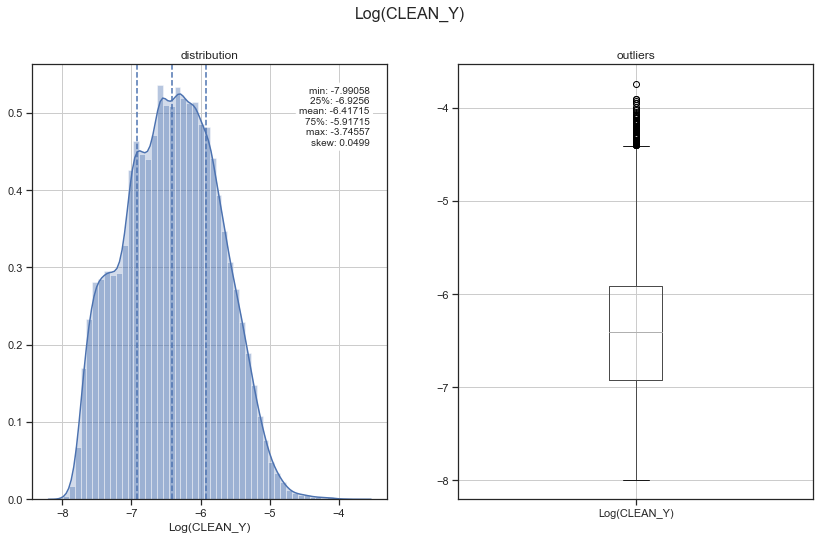

In [8]:
boxscores['Log(CLEAN_Y)'] = np.log(boxscores[clean_y])
boxscores['Log(CLEAN_Y)'] = boxscores['Log(CLEAN_Y)'].replace(-np.inf, np.nan)

helpers.visualize_variable_distribution(boxscores, 'Log(CLEAN_Y)', log_boxplot=False, figsize=(14, 8))

In [9]:
stat, p = shapiro(boxscores['Log(CLEAN_Y)'].dropna())
print(stat, p)

0.9899698495864868 0.0


Much better.

The distribution now contains a roughly equal amount of outliers on the left and right side, is less skewed, and is statistically normal

# Feature Engineering
Create new features from raw data using domain knowlege.

In [10]:
regressors = []
categorical_regressors = []

### Historical APS
First, I will create features that represent a player's historical APS.

I will start by calculating the running $APS$ of a player in a season.

In [11]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y'
)

regressors.append('AVG_Y')

Next, I will calculate the average $APS$ of a player in the previous games against the same opposing team in the same season.

In [12]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'OPP_TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_OPP_TEAM'
)

regressors.append('AVG_Y_OPP_TEAM')

Do more recent assist performances within a season matter more than previous ones?

To answer this, first I will calculate the Autocorrelation between a player's $APS$ and his previous $APS$ values:

$$ ACF(X_{0}, X_{i}) $$ <br>

Then, I will calculate the Partial Autocorrelation between between a player's $APS$ and his previous $APS$ values, using the lags in between as covariates:

$$ PACF(X_{0}, X_{i}  |  \{X_{j}\}_{0<j<i}) $$ <br>

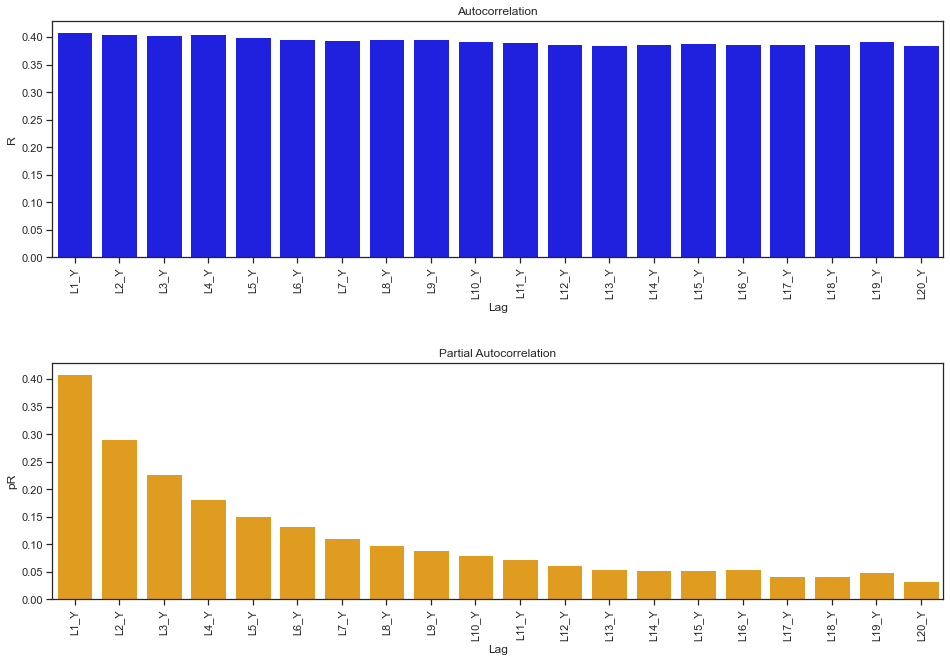

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

x_ticks = []
corrs = []
p_corrs = []
for i in range(1, 21):
    x = 'L{}_{}'.format(str(i), y)

    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=clean_y, new_col_name=x, n_shift=i
    )
    
    corr = boxscores[clean_y].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=x_ticks)
    
    corrs.append(corr)
    p_corrs.append(p_corr['r'][0])
    x_ticks.append(x)
    
corr_df = pd.DataFrame({'R': corrs, 'pR': p_corrs, 'Lag': x_ticks})

sns.barplot(x='Lag', y='R', data=corr_df, color='blue', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('Autocorrelation')

sns.barplot(x='Lag', y='pR', data=corr_df, color='orange', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('Partial Autocorrelation')

fig.tight_layout(pad=3.0)
plt.show()
plt.close()

While the Autocorrelaton of each between $APS$ and each $APS_{i}$ is similar, the Partial Autocorrelations exponentially decrease. This tells us that each $X_{i}$ tells us less new information than the preceding lag does. This is a reason for us to add the first lags to our list of regressors. It also makes the case that an exponentially weighted mean of previous lags may be more predictive than a normal mean.

In [14]:
regressors.append('L1_Y')

boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name='EWM_Y', alpha=0.90
)

regressors.append('EWM_Y')

Next, I will calculate the partial correlation between $APS$ and previous moveing averages of $APS$, using a covariate of the AVG_$APS$. The peak of this graph will tell us which MA provides the most new information on top of the average.

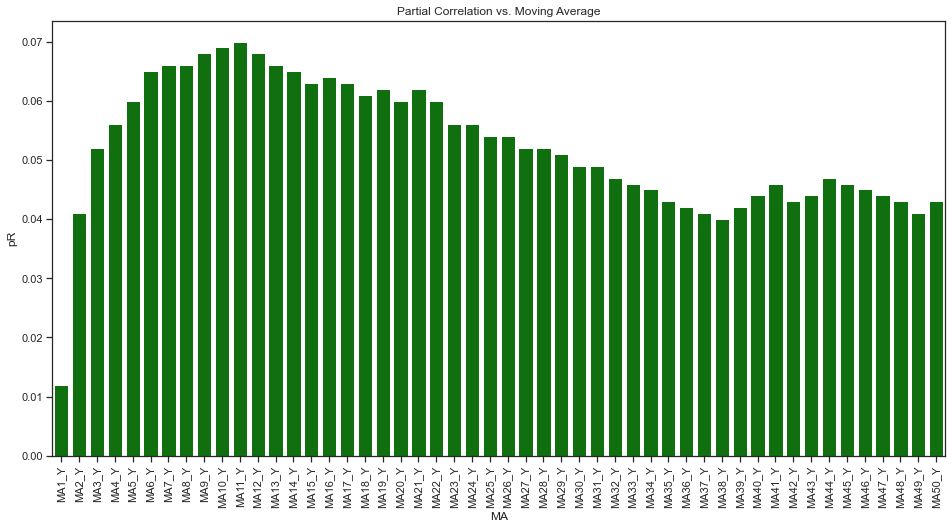

In [15]:
x_ticks = []
p_corrs = []
for i in range(1, 51):
    x = 'MA{}_{}'.format(str(i), y)

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=['AVG_Y'])
    
    x_ticks.append(x)
    p_corrs.append(p_corr['r'][0])
    
corr_df = pd.DataFrame({'pR': p_corrs, 'MA': x_ticks})
ax = sns.barplot(x='MA', y='pR', data=corr_df, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('Partial Correlation vs. Moving Average')
plt.show()
plt.close()

I will use MA2_$APS$, MA6_$APS$, and MA11_$APS$.

In [16]:
regressors.append('MA2_Y')
regressors.append('MA6_Y')
regressors.append('MA11_Y')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will visualize the difference of the distributions and means of $Y$ when a player is playing at Home or Away.

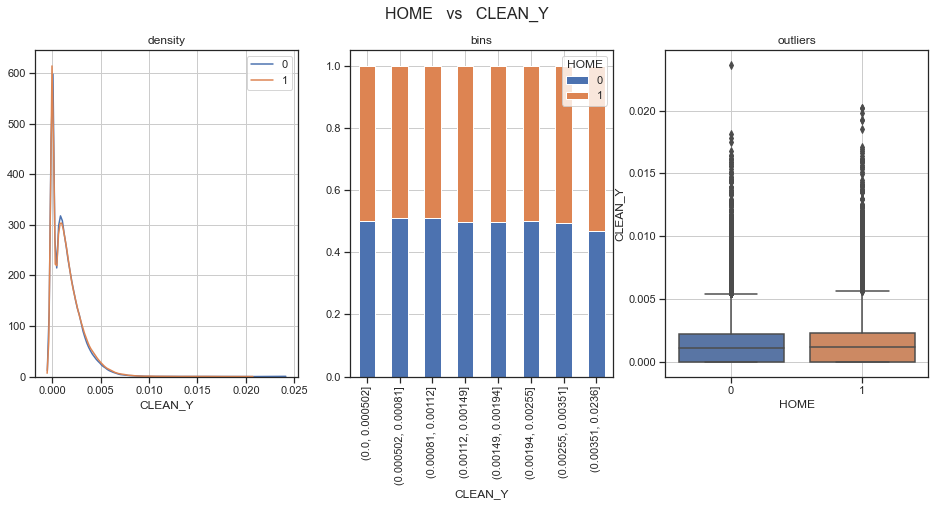

In [17]:
boxscores['HOME'] = 0
boxscores.loc[boxscores['TEAM'] == boxscores['HTM'], 'HOME'] = 1
helpers.visualize_categorical_x_vs_y(boxscores, 'HOME', clean_y)

There does not seem to be a relationship between the location a player plays at and his $APS$.

Next I will determine if a player's $APS$ depends on his status as a Starter.

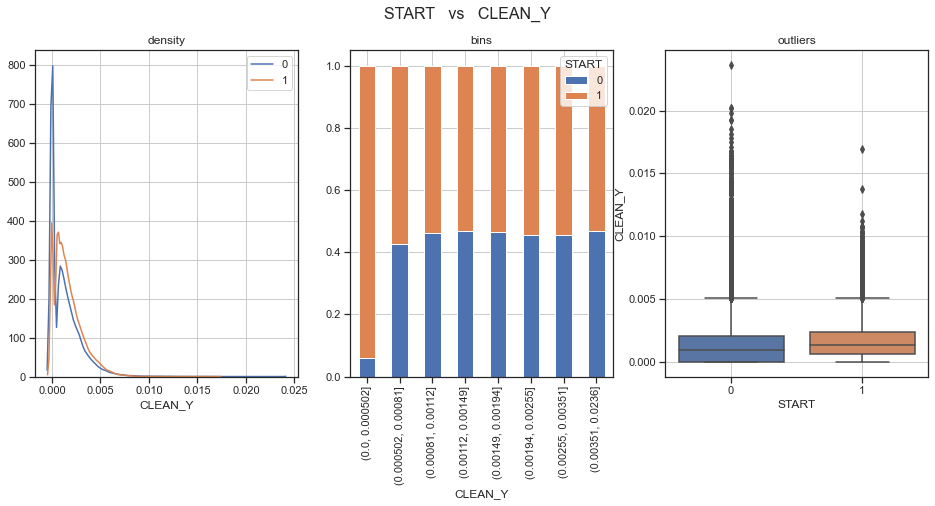

In [18]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', clean_y)

At a glance, it seems like there may be a slight relationship between starting status and $APS$.

To confirm this hypothesis, I will investigate the percentage of (season, player) groups in the dataset exhibit a statistically significant difference between their mean $APS$ when they start and are benched. To test significance, I will use a one-way ANOVA test.

In [19]:
num_valid_player_seasons = 0
significant_player_seasons = []
a = 0.01
for player_season, temp in boxscores.groupby(['SEASON', 'PLAYERID']):
    anova = pg.anova(dv=y, between='START', data=temp, detailed=False)
    p = anova['p-unc'].iloc[0]
    if p != '-':
        num_valid_player_seasons += 1
        if float(p) < a:
            significant_player_seasons.append(player_season)

print('Number of significant (season, player) combinations:', len(significant_player_seasons))
print('Percentage of significant (season, player) combinations:', len(significant_player_seasons)/num_valid_player_seasons)

Number of significant (season, player) combinations: 52
Percentage of significant (season, player) combinations: 0.029345372460496615


The percentage of (season, player) combinations that exibit a significant difference is 2.93%, almost twice our alpha of 1%. This is enough to add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $APS$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_Y\_R$.

In [20]:
regressors.append('START')
categorical_regressors.append('START')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_R'
)
regressors.append('AVG_Y_R')

Next, I will determine if the number of days a player rests is indicative of his $APS$.

In [21]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

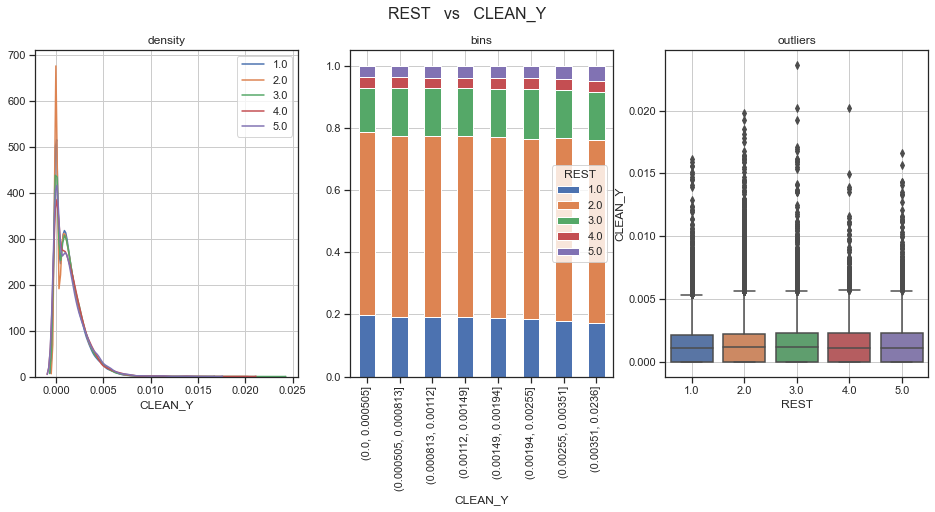

In [22]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', clean_y)

No significant relationship.

### Position
Next, I will determine if a player's position is indicative of his $APS$

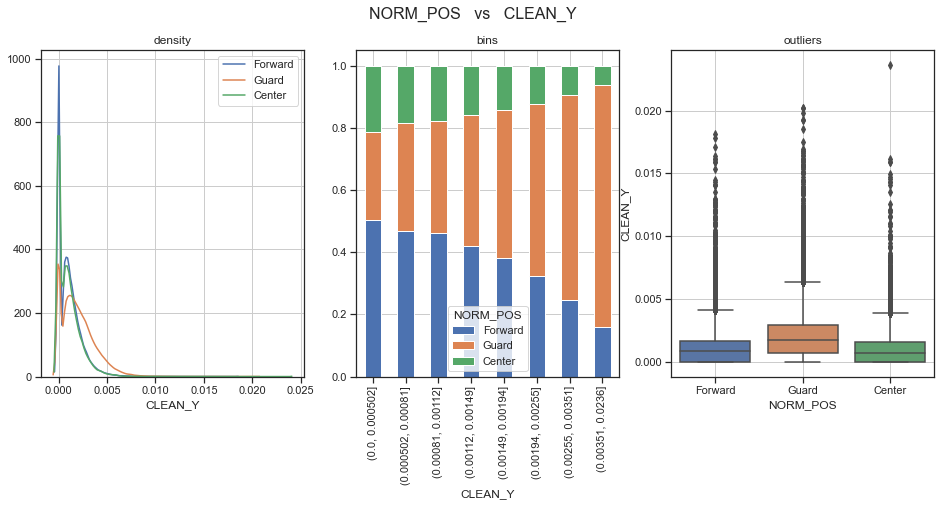

In [23]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

helpers.visualize_categorical_x_vs_y(boxscores, 'NORM_POS', clean_y)

In [24]:
boxscores['GUARD'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Guard', 'GUARD'] = 1

boxscores['FORWARD'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Forward', 'FORWARD'] = 1

boxscores['CENTER'] = 0
boxscores.loc[boxscores['NORM_POS'] == 'Center', 'CENTER'] = 1

regressors.append('GUARD')
regressors.append('FORWARD')
regressors.append('CENTER')

categorical_regressors.append('GUARD')
categorical_regressors.append('FORWARD')
categorical_regressors.append('CENTER')

### Defense
Next, I will create features based on the defense of the opposing team.

First, I will calculate the asssist defense of each team on a game-to-game basis. I will define three metrics to measure assist defense:

$$TEAM\_Y\_DIFF\_ALLOWED =  TEAM\_Y\_ALLOWED - TEAM\_Y\_AVG$$

where $TEAM\_Y\_ALLOWED$ is the $APS$ allowed to the opposing team and $TEAM\_Y\_AVG$ is the $APS$ of that team throughout the season coming into the game.

In [25]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='AST', new_col_name='AVG_AST'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='AVG_SP'
)

temp = boxscores.dropna(subset=['AST', 'SECONDSPLAYED', 'AVG_AST', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED': x['AST'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG': x['AVG_AST'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED'] - grouped_defensive_boxscores['TEAM_Y_AVG']

Next, I will visualize the defense of each team for each season in the dataset. I will also run a one-way ANOVA test to determine if the mean $TEAM\_Y\_DIFF\_ALLOWED$ differs among the teams in each season.

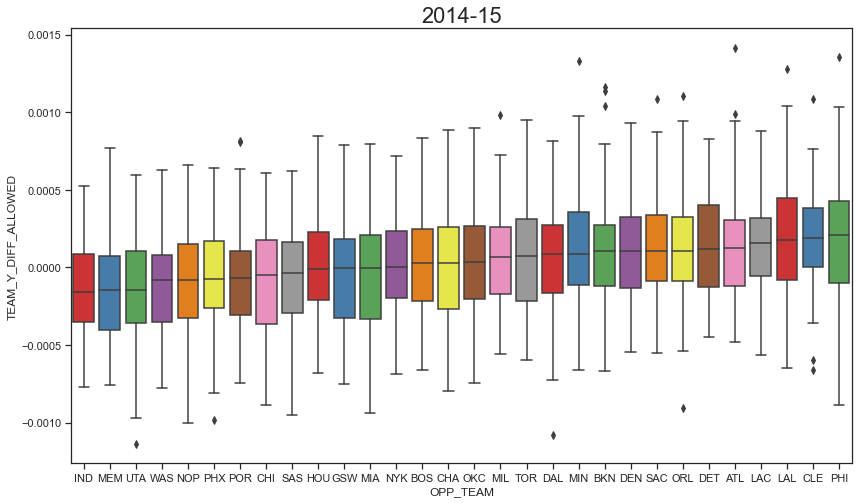

Team defenses are statistically siginficantly different


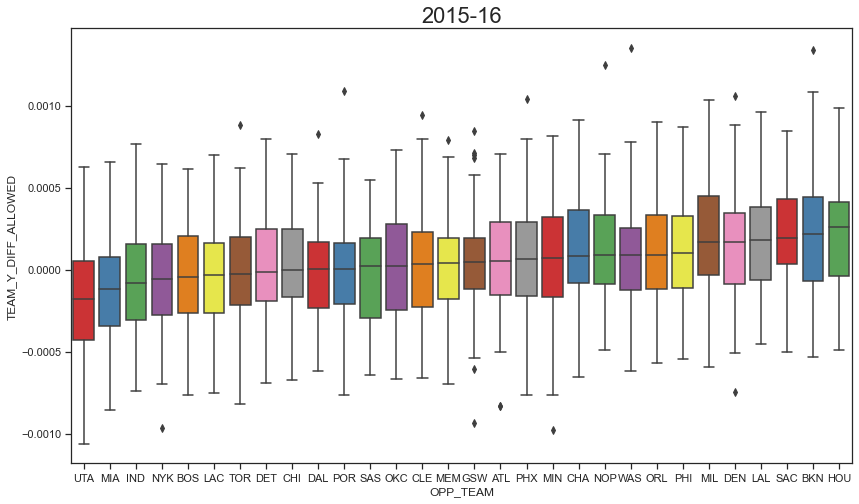

Team defenses are statistically siginficantly different


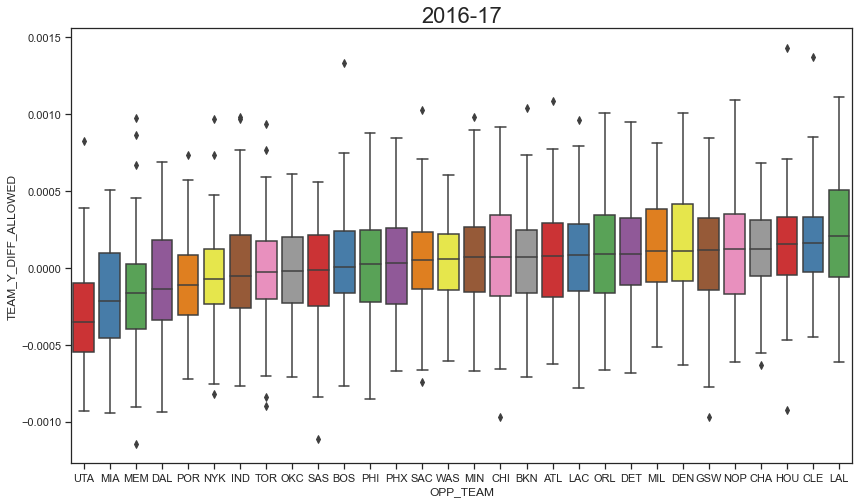

Team defenses are statistically siginficantly different


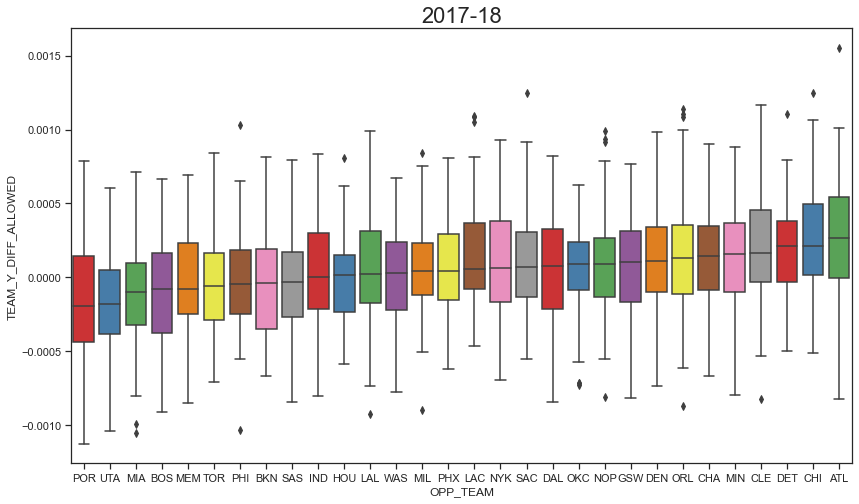

Team defenses are statistically siginficantly different


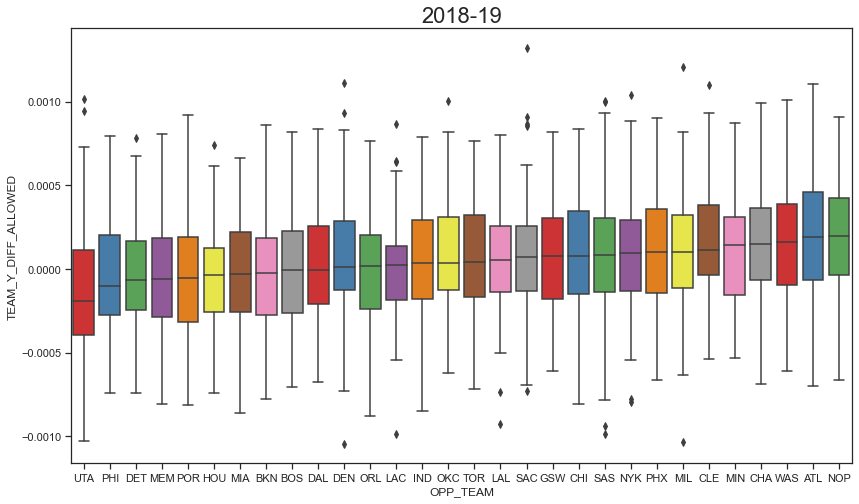

Team defenses are statistically siginficantly different


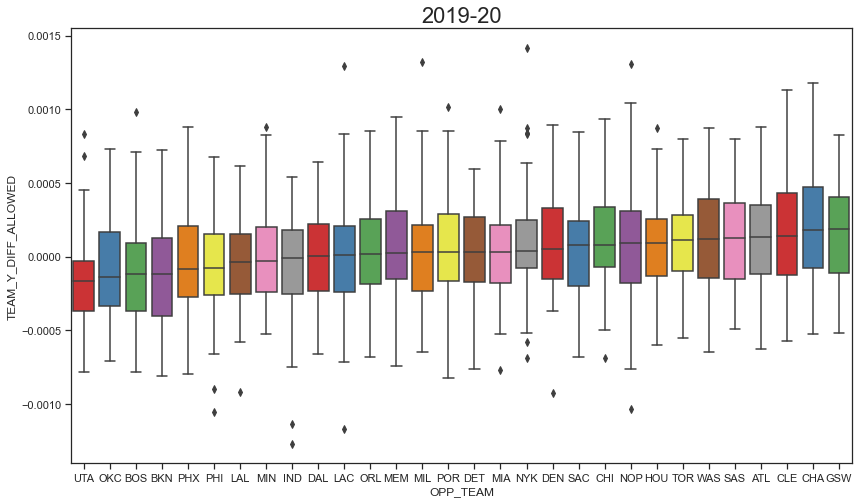

Team defenses are statistically siginficantly different


In [26]:
a = 0.01
for season, temp in grouped_defensive_boxscores.groupby(['SEASON']):
    plt.figure(figsize=(14, 8))
    plt.title(season,fontsize=22)
    opp_team_def = [
        (opp_team, temp2['TEAM_Y_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    opp_team_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in opp_team_def]
    sns.boxplot(x="OPP_TEAM", y="TEAM_Y_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams)
    
    plt.show()
    plt.close()
    
    anova = pg.anova(dv='TEAM_Y_DIFF_ALLOWED', between='OPP_TEAM', data=temp, detailed=True)
    p = anova['p-unc'].iloc[0]
    if p < a:
        print('Team defenses are statistically siginficantly different')
    else:
        print('Team defenses are not statistically siginficantly different')

Now, I will calculate the average assist defense of the opposing team across all previous games in a season, $AVG\_TEAM\_Y\_DIFF\_ALLOWED$.

In [27]:
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_Y_DIFF_ALLOWED', new_col_name='AVG_TEAM_Y_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

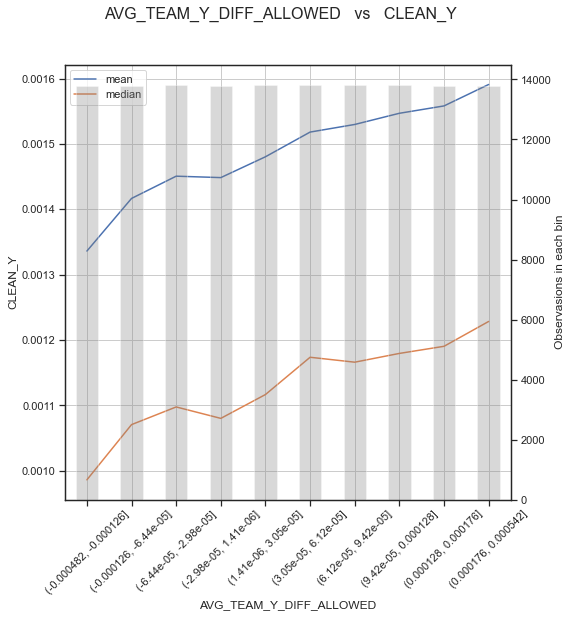

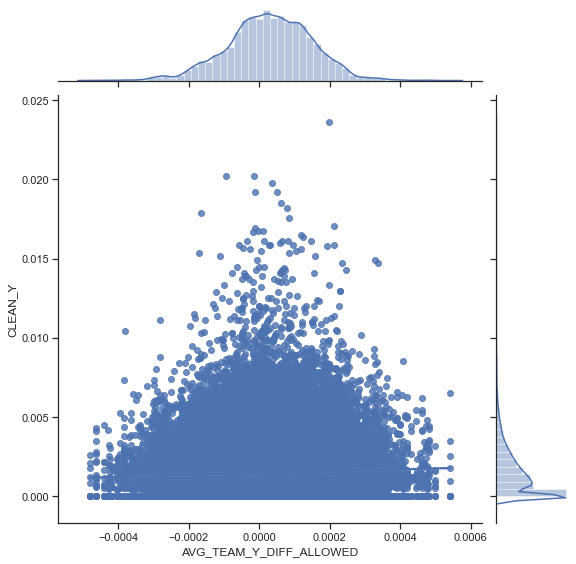

In [28]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED', clean_y, figsize=(8, 8))

In [29]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED')

The metrics above track the opposing team's assist defense on all players. However, an opposing team's assist defense may differ among starts and bench players, as each set will have a mostly different group of opposing players.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_R$ to quantify a team's defense on opposing players by role (start/bench).

In [30]:
temp = boxscores.dropna(subset=['AST', 'SECONDSPLAYED', 'AVG_AST', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'START', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_R': x['AST'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_R': x['AVG_AST'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_R'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_R'] - grouped_defensive_boxscores['TEAM_Y_AVG_R']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'START'], col_name='TEAM_Y_DIFF_ALLOWED_R',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_R', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'START'], how='left')

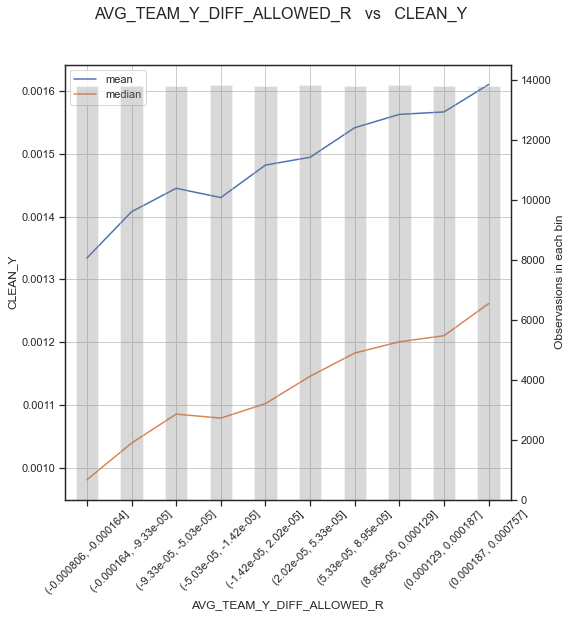

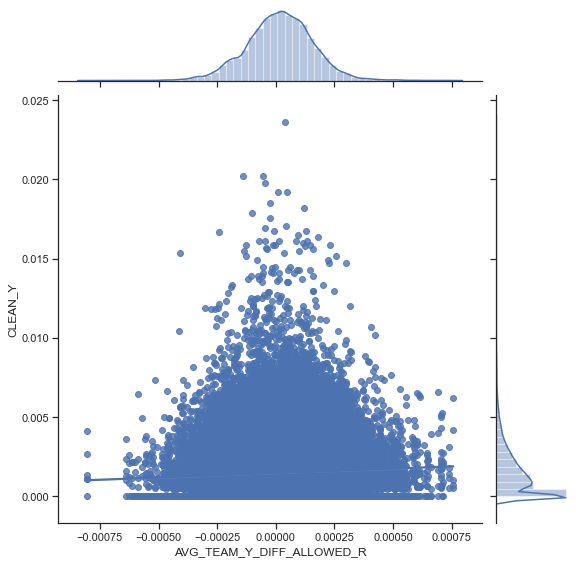

In [31]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_R', clean_y, figsize=(8, 8))

In [32]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED_R')

Opposing teams may also allow more/less rebounds to different positions.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_P$ to quantify a team's assist defense on opposing players by role (guard/forward/center).

In [33]:
temp = boxscores.dropna(subset=['AST', 'SECONDSPLAYED', 'AVG_AST', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_P': x['AST'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_P': x['AVG_AST'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_Y_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='TEAM_Y_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

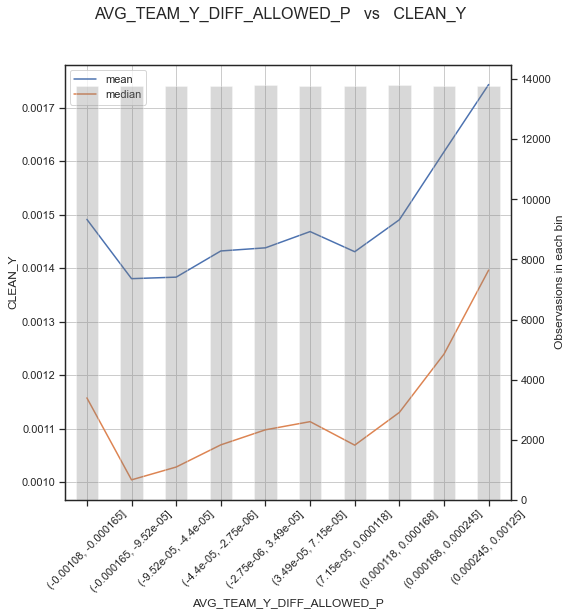

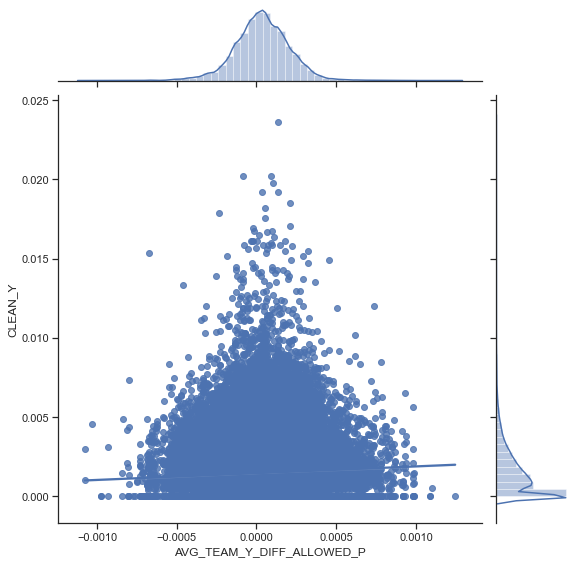

In [34]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_P', clean_y, figsize=(8, 8))

In [35]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED_P')

I will also include the vegas implied game point total as a feature.

In [36]:
odds = query_data.query_odds_data()
odds['TOTAL'] = odds['TOTAL'].replace(['PK', '-'], np.nan)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [37]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

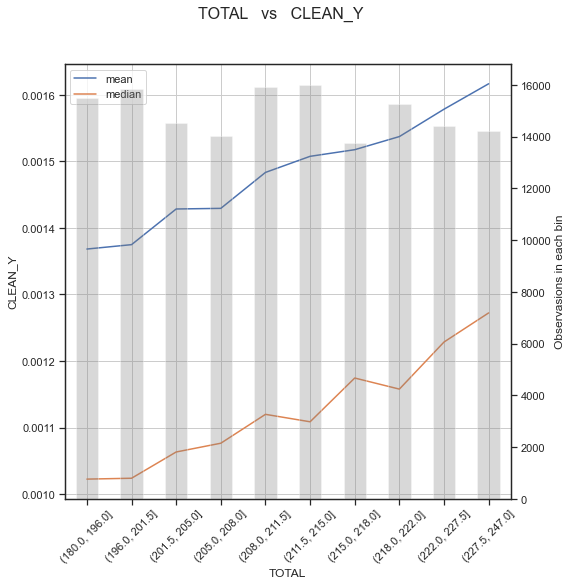

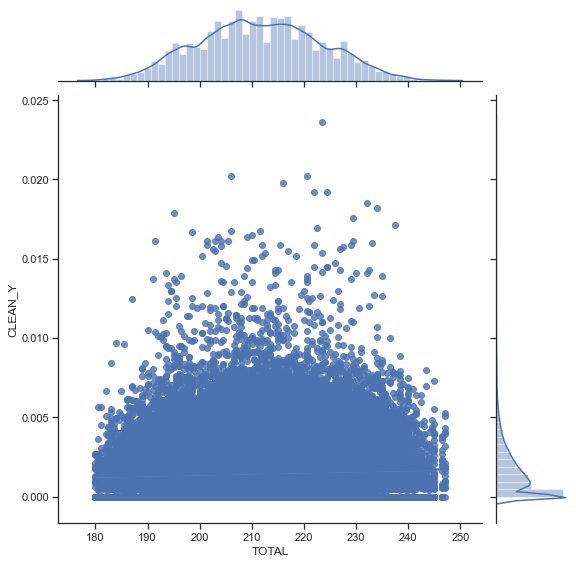

In [38]:
helpers.visualize_numeric_x_vs_y(boxscores, 'TOTAL', clean_y, figsize=(8, 8))

In [39]:
regressors.append('TOTAL')

### Injuries
Finally, I will create features that quantify how injured the lineup is from a production standpoint.

The first variable I will create to capture how injured the lineup is (from an assisy standpoint) will be called $TEAM\_ACTIVE\_AVG\_Y\_DIFF$. This will capture the difference between the $APS$ of the players of a team active in a game, and the average $APS$ of that team. For example, if the sum of the average seconds played of the active players on a team was 14400, and the sum of the average $AST$ of the active players on the team was 30, the $TEAM\_ACTIVE\_AVG\_Y$ would be $30/14400 = 0.00208$. If the next game, Chris Paul was out (who is on the team and averaged 2000 seconds played and 10 $AST$) the $TEAM\_ACTIVE\_AVG\_Y$ would be $(30-10)/(14400-2000) = 0.00161$. In this case $TEAM\_ACTIVE\_AVG\_Y\_DIFF$ would be $0.00161-0.00208 = -0.000467$. This lower number would hopefully be more indicative of a higher $APS$ for the rest of the team.

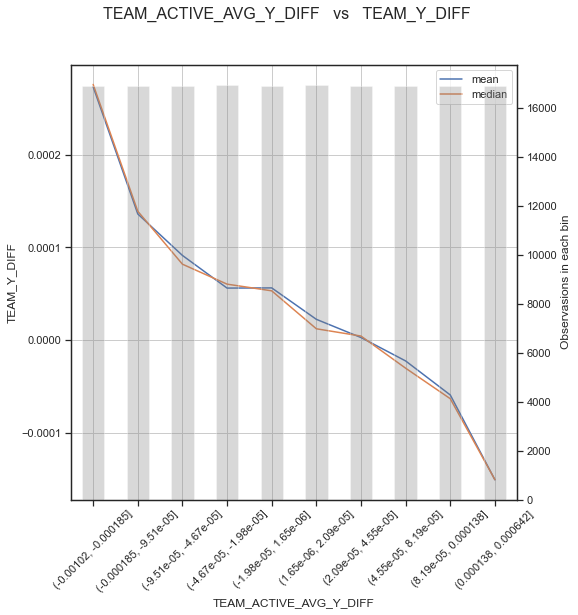

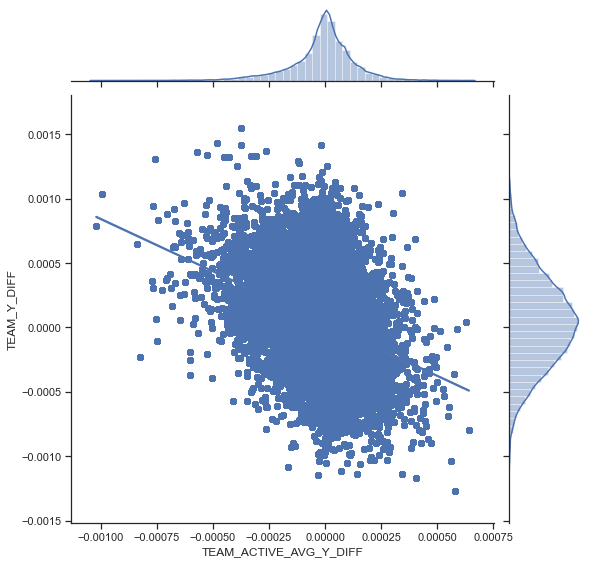

In [40]:
temp = boxscores.dropna(subset=['AVG_SP', 'AVG_AST', 'AST', 'SECONDSPLAYED'])
temp = temp.groupby(['SEASON', 'GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_ACTIVE_AVG_Y': x['AVG_AST'].sum()/x['AVG_SP'].sum(),
        'TEAM_Y': x['AST'].sum()/x['SECONDSPLAYED'].sum()
    })
)
temp = feature_creation.expanding_mean(
    df=temp, group_col_names=['SEASON', 'TEAM'], col_name='TEAM_Y', new_col_name='AVG_TEAM_Y'
)

temp['TEAM_ACTIVE_AVG_Y_DIFF'] = temp['TEAM_ACTIVE_AVG_Y'] - temp['AVG_TEAM_Y']
temp['TEAM_Y_DIFF'] = temp['TEAM_Y'] - temp['TEAM_ACTIVE_AVG_Y']

boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')
helpers.visualize_numeric_x_vs_y(boxscores, 'TEAM_ACTIVE_AVG_Y_DIFF', 'TEAM_Y_DIFF', figsize=(8, 8))

It seems as though a lower $TEAM\_ACTIVE\_AVG\_Y\_DIFF$ is indicative of a higher $TEAM\_Y$ than the active players average. I will add this to my list of regressors.

In [41]:
regressors.append('TEAM_ACTIVE_AVG_Y_DIFF')

Not all players absorb lost usage equally. To account for this, I will create a feature that tracks the $AVG\_Y$ of players when the starting lineup was the same. I will also create a feature that tracks the $AVG\_Y$ of players when the active star players on the team were the same (I will define 'star player' in this context as a player who averages at least 6.5 Assists Rebounds Per Game).

In [42]:
boxscores['START_LINEUP'] = np.nan
boxscores['STARS'] = np.nan
boxscores = boxscores.set_index(['GAMEID', 'TEAM'])
for (game_id, team), temp in boxscores.groupby(['GAMEID', 'TEAM']):
    start_lineup = list(temp.loc[temp['START'] == 1, 'PLAYERID'].values)
    start_lineup.sort()
    start_lineup = '_'.join(start_lineup)
    boxscores.loc[(game_id, team), 'START_LINEUP'] = start_lineup
    
    stars = list(temp.loc[temp['AVG_AST'] >= 6.5, 'PLAYERID'].values)
    stars.sort()
    stars = '_'.join(stars)
    boxscores.loc[(game_id, team), 'STARS'] = stars
boxscores = boxscores.reset_index()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'START_LINEUP', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARTERS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'STARS', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARS'
)

To determine if these features provide new information, I will calcuate the partial correlation between each of them and the dependant variable, using $AVG\_Y$ as the covariate.

In [43]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='Y', weight_col_name='SECONDSPLAYED', new_col_name='AVG_Y'
)

print('Partial correlation between AVG_Y_STARTERS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARTERS', y=clean_y, covar=['AVG_Y'])
display(pc)

print('Partial correlation between AVG_Y_STARS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARS', y=clean_y, covar=['AVG_Y'])
display(pc)

Partial correlation between AVG_Y_STARTERS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,110230,0.015,"[0.01, 0.02]",0.0,0.0,8.405566e-07,700.475,0.998


Partial correlation between AVG_Y_STARS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,143006,0.02,"[0.01, 0.02]",0.0,0.0,7.255472e-14,4.786e+09,1.0


These features both show a significant partial correlation with the dependent variable. I will add them to the list of regressors.

In [44]:
regressors.append('AVG_Y_STARTERS')
regressors.append('AVG_Y_STARS')

### Weights
Lastly, I will add a column to weight each $Y$ value. I do not care about each occurance of the dependant variable equally; the $APS$ of a player who dishes 1 assist in 180 seconds should not be weighted the same as the $APS$ of a plyer who dishes 10 assists in 1800 seconds. 

The weight I will use will be a product of functions of the amount of seconds played in a game and the sum of seconds played by a player throughout that season:

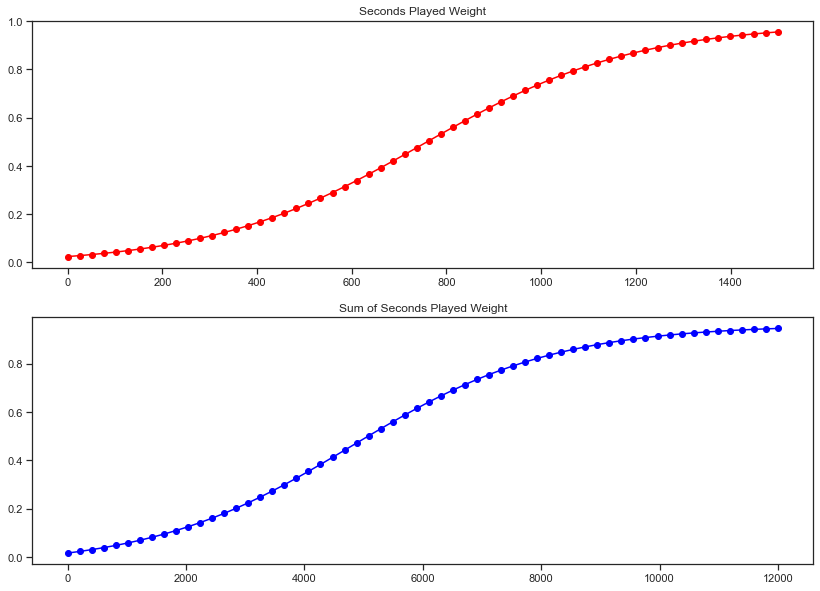

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-0.80*x + 600)/180)) - 0.01
sp_in_array = np.linspace(0, 60*25, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-0.175*x + 840)/300)) - 0.04
tsp_in_array = np.linspace(0, 60*20*10, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Seconds Played Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Seconds Played Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show() 

In [46]:
boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='SUM_SP'
)

w = 'WEIGHT'
boxscores[w] = boxscores['SECONDSPLAYED'].apply(sp_weight_func) * boxscores['SUM_SP'].apply(tsp_weight_func)

Some features we created to track historical performances mean less if the player has played less games/ minutes. To tell the non-linear models how much the player has played, I will create 2 regressors: number of games played ($COUNT\_GP$) and average seconds played ($AVG\_SP$)

In [47]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')


regressors.append('AVG_SP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

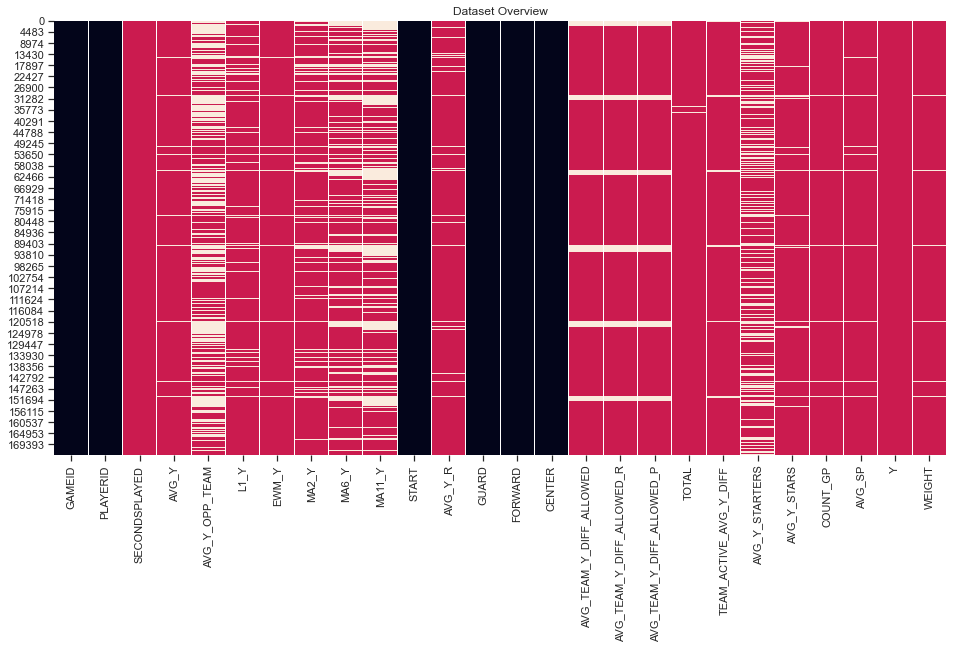

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 67.445


In [48]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID', 'SECONDSPLAYED'] + regressors + [y] + [w]]

#drop games in which players played a minute or less
feature_matrix = feature_matrix.loc[feature_matrix['SECONDSPLAYED'] > 60]

helpers.visualize_dataframe(feature_matrix)

In [49]:
feature_matrix['AVG_Y_OPP_TEAM'] = feature_matrix['AVG_Y_OPP_TEAM'].fillna(feature_matrix['AVG_Y'])

feature_matrix['L1_Y'] = feature_matrix['L1_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['EWM_Y'] = feature_matrix['EWM_Y'].fillna(feature_matrix['AVG_Y'])

feature_matrix['MA2_Y'] = feature_matrix['MA2_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA6_Y'] = feature_matrix['MA6_Y'].fillna(feature_matrix['MA2_Y'])
feature_matrix['MA11_Y'] = feature_matrix['MA11_Y'].fillna(feature_matrix['MA6_Y'])

feature_matrix['AVG_Y_R'] = feature_matrix['AVG_Y_R'].fillna(feature_matrix['AVG_Y'])

feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_R'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_R'].fillna(0)
feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(200)

feature_matrix['TEAM_ACTIVE_AVG_Y_DIFF'] = feature_matrix['TEAM_ACTIVE_AVG_Y_DIFF'].fillna(0)
feature_matrix['AVG_Y_STARS'] = feature_matrix['AVG_Y_STARS'].fillna(feature_matrix['AVG_Y'])
feature_matrix['AVG_Y_STARTERS'] = feature_matrix['AVG_Y_STARTERS'].fillna(feature_matrix['AVG_Y_STARS'])

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

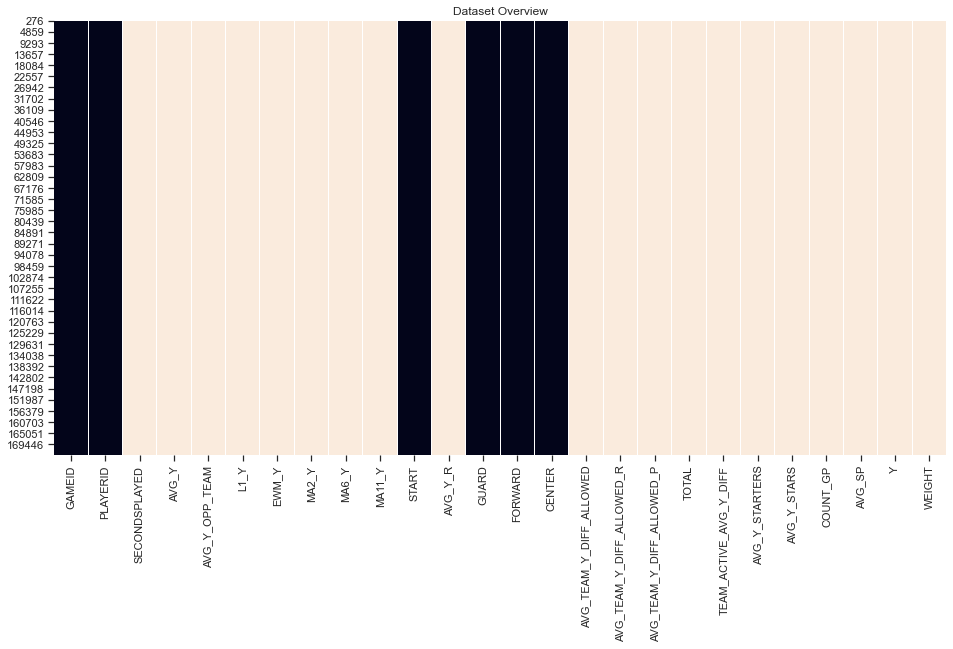

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [50]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [51]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    },
    {
        'Function': lambda x: np.log(x + 1),
        'Inverse Function': lambda x: np.exp(x) - 1,
        'Name': 'Log'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            temp_feature_matrix = feature_matrix.copy()
            temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[numeric_regressors] = x_scaler.fit_transform(temp_feature_matrix[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                temp_feature_matrix[[y]] = y_scaler.fit_transform(temp_feature_matrix[[y]])

            # feature selection
            X = temp_feature_matrix[regressors]
            Y = temp_feature_matrix[y]
            W = temp_feature_matrix[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)

            X = temp_feature_matrix[selected_features].values
            Y = temp_feature_matrix[y].values
            W = temp_feature_matrix[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('\nModel:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'MA2_Y', 'MA6_Y', 'MA11_Y', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_R', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_Y_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS']
Mean MAE: 0.000819403807942341

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_Y', 'MA6_Y', 'MA11_Y', 'START', 'AVG_Y_R', 'GUARD', 'FORWARD', 'CENTER', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_Y_DIFF', 'AVG_Y_STARS', 'AVG_SP']
Mean MAE: 0.0008186304110008116

Model: LinearRegression()
Transformer: Log
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'MA2_Y', 'MA6_Y', 'MA11_Y', 'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_R', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_Y_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS']
Mean MAE: 0.0008193391472998922

Model: LinearRegression()
Transformer: Log
Scale: True
Selected Features: ['AVG_Y', 'MA

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [52]:
selected_features = ['AVG_Y', 'AVG_Y_OPP_TEAM', 'L1_Y', 'EWM_Y', 'MA2_Y', 'MA6_Y', 'MA11_Y',
                     'AVG_Y_R', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_R',
                     'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'TEAM_ACTIVE_AVG_Y_DIFF', 'AVG_Y_STARTERS',
                     'AVG_Y_STARS', 'COUNT_GP', 'AVG_SP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [53]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 0.0010978	test: 0.0011770	best: 0.0011770 (0)	total: 11.7ms	remaining: 58.7s
1:	learn: 0.0010887	test: 0.0011685	best: 0.0011685 (1)	total: 21.3ms	remaining: 53.1s
2:	learn: 0.0010800	test: 0.0011604	best: 0.0011604 (2)	total: 30.3ms	remaining: 50.5s
3:	learn: 0.0010716	test: 0.0011526	best: 0.0011526 (3)	total: 40.1ms	remaining: 50s
4:	learn: 0.0010636	test: 0.0011453	best: 0.0011453 (4)	total: 49.2ms	remaining: 49.2s
5:	learn: 0.0010557	test: 0.0011380	best: 0.0011380 (5)	total: 58.5ms	remaining: 48.7s
6:	learn: 0.0010480	test: 0.0011309	best: 0.0011309 (6)	total: 68.2ms	remaining: 48.7s
7:	learn: 0.0010407	test: 0.0011241	best: 0.0011241 (7)	total: 77.5ms	remaining: 48.4s
8:	learn: 0.0010335	test: 0.0011173	best: 0.0011173 (8)	total: 86.5ms	remaining: 48s
9:	learn: 0.0010266	test: 0.0011108	best: 0.0011108 (9)	total: 95.5ms	remaining: 47.6s
10:	learn: 0.0010198	test: 0.0011045	best: 0.0011045 (10)	total: 105ms	remaining: 47.6s
11:	learn: 0.0010133	test: 0.0010985	best: 0.0

105:	learn: 0.0008277	test: 0.0009249	best: 0.0009249 (105)	total: 997ms	remaining: 46s
106:	learn: 0.0008274	test: 0.0009246	best: 0.0009246 (106)	total: 1.01s	remaining: 46s
107:	learn: 0.0008271	test: 0.0009243	best: 0.0009243 (107)	total: 1.01s	remaining: 46s
108:	learn: 0.0008268	test: 0.0009239	best: 0.0009239 (108)	total: 1.02s	remaining: 46s
109:	learn: 0.0008265	test: 0.0009237	best: 0.0009237 (109)	total: 1.04s	remaining: 46.1s
110:	learn: 0.0008262	test: 0.0009233	best: 0.0009233 (110)	total: 1.05s	remaining: 46.1s
111:	learn: 0.0008260	test: 0.0009231	best: 0.0009231 (111)	total: 1.05s	remaining: 46s
112:	learn: 0.0008257	test: 0.0009228	best: 0.0009228 (112)	total: 1.06s	remaining: 46s
113:	learn: 0.0008255	test: 0.0009226	best: 0.0009226 (113)	total: 1.07s	remaining: 46s
114:	learn: 0.0008252	test: 0.0009224	best: 0.0009224 (114)	total: 1.08s	remaining: 46s
115:	learn: 0.0008250	test: 0.0009221	best: 0.0009221 (115)	total: 1.09s	remaining: 45.9s
116:	learn: 0.0008248	test

213:	learn: 0.0008153	test: 0.0009113	best: 0.0009113 (213)	total: 2s	remaining: 44.7s
214:	learn: 0.0008153	test: 0.0009113	best: 0.0009113 (214)	total: 2.01s	remaining: 44.7s
215:	learn: 0.0008153	test: 0.0009112	best: 0.0009112 (215)	total: 2.02s	remaining: 44.7s
216:	learn: 0.0008152	test: 0.0009112	best: 0.0009112 (216)	total: 2.02s	remaining: 44.6s
217:	learn: 0.0008152	test: 0.0009111	best: 0.0009111 (217)	total: 2.03s	remaining: 44.6s
218:	learn: 0.0008151	test: 0.0009111	best: 0.0009111 (218)	total: 2.04s	remaining: 44.6s
219:	learn: 0.0008151	test: 0.0009111	best: 0.0009111 (219)	total: 2.05s	remaining: 44.6s
220:	learn: 0.0008151	test: 0.0009110	best: 0.0009110 (220)	total: 2.06s	remaining: 44.6s
221:	learn: 0.0008150	test: 0.0009110	best: 0.0009110 (221)	total: 2.07s	remaining: 44.5s
222:	learn: 0.0008150	test: 0.0009109	best: 0.0009109 (222)	total: 2.08s	remaining: 44.5s
223:	learn: 0.0008150	test: 0.0009109	best: 0.0009109 (223)	total: 2.09s	remaining: 44.5s
224:	learn: 0

325:	learn: 0.0008125	test: 0.0009085	best: 0.0009085 (325)	total: 2.99s	remaining: 42.9s
326:	learn: 0.0008125	test: 0.0009084	best: 0.0009084 (326)	total: 3s	remaining: 42.9s
327:	learn: 0.0008125	test: 0.0009084	best: 0.0009084 (327)	total: 3.01s	remaining: 42.9s
328:	learn: 0.0008125	test: 0.0009084	best: 0.0009084 (328)	total: 3.02s	remaining: 42.9s
329:	learn: 0.0008125	test: 0.0009084	best: 0.0009084 (329)	total: 3.03s	remaining: 42.9s
330:	learn: 0.0008124	test: 0.0009084	best: 0.0009084 (330)	total: 3.04s	remaining: 42.9s
331:	learn: 0.0008124	test: 0.0009084	best: 0.0009084 (331)	total: 3.05s	remaining: 42.9s
332:	learn: 0.0008124	test: 0.0009084	best: 0.0009084 (332)	total: 3.06s	remaining: 42.8s
333:	learn: 0.0008124	test: 0.0009084	best: 0.0009084 (332)	total: 3.06s	remaining: 42.8s
334:	learn: 0.0008124	test: 0.0009084	best: 0.0009084 (334)	total: 3.07s	remaining: 42.8s
335:	learn: 0.0008123	test: 0.0009084	best: 0.0009084 (335)	total: 3.08s	remaining: 42.8s
336:	learn: 0

436:	learn: 0.0008108	test: 0.0009077	best: 0.0009077 (436)	total: 3.99s	remaining: 41.6s
437:	learn: 0.0008108	test: 0.0009077	best: 0.0009077 (437)	total: 4s	remaining: 41.7s
438:	learn: 0.0008108	test: 0.0009077	best: 0.0009077 (437)	total: 4.01s	remaining: 41.7s
439:	learn: 0.0008108	test: 0.0009077	best: 0.0009077 (437)	total: 4.02s	remaining: 41.7s
440:	learn: 0.0008108	test: 0.0009077	best: 0.0009077 (437)	total: 4.03s	remaining: 41.7s
441:	learn: 0.0008108	test: 0.0009077	best: 0.0009077 (441)	total: 4.04s	remaining: 41.7s
442:	learn: 0.0008108	test: 0.0009077	best: 0.0009077 (442)	total: 4.05s	remaining: 41.6s
443:	learn: 0.0008107	test: 0.0009077	best: 0.0009077 (443)	total: 4.06s	remaining: 41.6s
444:	learn: 0.0008107	test: 0.0009077	best: 0.0009077 (444)	total: 4.07s	remaining: 41.6s
445:	learn: 0.0008107	test: 0.0009077	best: 0.0009077 (444)	total: 4.07s	remaining: 41.6s
446:	learn: 0.0008107	test: 0.0009077	best: 0.0009077 (446)	total: 4.08s	remaining: 41.6s
447:	learn: 0

545:	learn: 0.0008093	test: 0.0009073	best: 0.0009073 (545)	total: 4.97s	remaining: 40.5s
546:	learn: 0.0008093	test: 0.0009073	best: 0.0009073 (546)	total: 4.98s	remaining: 40.5s
547:	learn: 0.0008093	test: 0.0009072	best: 0.0009072 (547)	total: 4.99s	remaining: 40.5s
548:	learn: 0.0008093	test: 0.0009072	best: 0.0009072 (548)	total: 5s	remaining: 40.5s
549:	learn: 0.0008093	test: 0.0009072	best: 0.0009072 (549)	total: 5.01s	remaining: 40.5s
550:	learn: 0.0008093	test: 0.0009072	best: 0.0009072 (550)	total: 5.01s	remaining: 40.5s
551:	learn: 0.0008092	test: 0.0009072	best: 0.0009072 (551)	total: 5.02s	remaining: 40.5s
552:	learn: 0.0008092	test: 0.0009072	best: 0.0009072 (552)	total: 5.03s	remaining: 40.5s
553:	learn: 0.0008092	test: 0.0009072	best: 0.0009072 (553)	total: 5.04s	remaining: 40.5s
554:	learn: 0.0008092	test: 0.0009072	best: 0.0009072 (554)	total: 5.05s	remaining: 40.5s
555:	learn: 0.0008092	test: 0.0009072	best: 0.0009072 (554)	total: 5.06s	remaining: 40.4s
556:	learn: 0

637:	learn: 0.0008081	test: 0.0009070	best: 0.0009070 (630)	total: 5.77s	remaining: 39.5s
638:	learn: 0.0008081	test: 0.0009070	best: 0.0009070 (630)	total: 5.78s	remaining: 39.4s
639:	learn: 0.0008081	test: 0.0009070	best: 0.0009070 (630)	total: 5.79s	remaining: 39.4s
640:	learn: 0.0008081	test: 0.0009070	best: 0.0009070 (630)	total: 5.8s	remaining: 39.4s
641:	learn: 0.0008080	test: 0.0009070	best: 0.0009070 (630)	total: 5.81s	remaining: 39.4s
642:	learn: 0.0008080	test: 0.0009070	best: 0.0009070 (630)	total: 5.82s	remaining: 39.4s
643:	learn: 0.0008080	test: 0.0009070	best: 0.0009070 (630)	total: 5.82s	remaining: 39.4s
644:	learn: 0.0008080	test: 0.0009070	best: 0.0009070 (630)	total: 5.83s	remaining: 39.4s
645:	learn: 0.0008080	test: 0.0009070	best: 0.0009070 (630)	total: 5.84s	remaining: 39.4s
646:	learn: 0.0008080	test: 0.0009070	best: 0.0009070 (630)	total: 5.85s	remaining: 39.4s
647:	learn: 0.0008079	test: 0.0009070	best: 0.0009070 (630)	total: 5.86s	remaining: 39.4s
648:	learn:

# Evaluation
Lastly, I will evaluate the final model.

In [54]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 0.0010978	test: 0.0010945	best: 0.0010945 (0)	total: 12ms	remaining: 59.9s
1:	learn: 0.0010887	test: 0.0010853	best: 0.0010853 (1)	total: 21.3ms	remaining: 53.2s
2:	learn: 0.0010800	test: 0.0010766	best: 0.0010766 (2)	total: 30.4ms	remaining: 50.6s
3:	learn: 0.0010716	test: 0.0010681	best: 0.0010681 (3)	total: 39.8ms	remaining: 49.7s
4:	learn: 0.0010636	test: 0.0010601	best: 0.0010601 (4)	total: 49ms	remaining: 49s
5:	learn: 0.0010557	test: 0.0010522	best: 0.0010522 (5)	total: 58.9ms	remaining: 49s
6:	learn: 0.0010480	test: 0.0010445	best: 0.0010445 (6)	total: 68.1ms	remaining: 48.6s
7:	learn: 0.0010407	test: 0.0010371	best: 0.0010371 (7)	total: 77.2ms	remaining: 48.2s
8:	learn: 0.0010335	test: 0.0010298	best: 0.0010298 (8)	total: 86.2ms	remaining: 47.8s
9:	learn: 0.0010266	test: 0.0010228	best: 0.0010228 (9)	total: 95.6ms	remaining: 47.7s
10:	learn: 0.0010198	test: 0.0010160	best: 0.0010160 (10)	total: 105ms	remaining: 47.6s
11:	learn: 0.0010133	test: 0.0010094	best: 0.00100

108:	learn: 0.0008268	test: 0.0008244	best: 0.0008244 (108)	total: 1.01s	remaining: 45.6s
109:	learn: 0.0008265	test: 0.0008241	best: 0.0008241 (109)	total: 1.02s	remaining: 45.5s
110:	learn: 0.0008262	test: 0.0008238	best: 0.0008238 (110)	total: 1.03s	remaining: 45.5s
111:	learn: 0.0008260	test: 0.0008236	best: 0.0008236 (111)	total: 1.04s	remaining: 45.5s
112:	learn: 0.0008257	test: 0.0008233	best: 0.0008233 (112)	total: 1.05s	remaining: 45.5s
113:	learn: 0.0008255	test: 0.0008231	best: 0.0008231 (113)	total: 1.06s	remaining: 45.5s
114:	learn: 0.0008252	test: 0.0008229	best: 0.0008229 (114)	total: 1.07s	remaining: 45.4s
115:	learn: 0.0008250	test: 0.0008227	best: 0.0008227 (115)	total: 1.08s	remaining: 45.4s
116:	learn: 0.0008248	test: 0.0008225	best: 0.0008225 (116)	total: 1.09s	remaining: 45.4s
117:	learn: 0.0008245	test: 0.0008222	best: 0.0008222 (117)	total: 1.1s	remaining: 45.4s
118:	learn: 0.0008243	test: 0.0008220	best: 0.0008220 (118)	total: 1.11s	remaining: 45.4s
119:	learn:

215:	learn: 0.0008153	test: 0.0008142	best: 0.0008142 (215)	total: 2.04s	remaining: 45.2s
216:	learn: 0.0008152	test: 0.0008142	best: 0.0008142 (216)	total: 2.05s	remaining: 45.1s
217:	learn: 0.0008152	test: 0.0008141	best: 0.0008141 (217)	total: 2.06s	remaining: 45.1s
218:	learn: 0.0008151	test: 0.0008141	best: 0.0008141 (218)	total: 2.07s	remaining: 45.1s
219:	learn: 0.0008151	test: 0.0008141	best: 0.0008141 (219)	total: 2.08s	remaining: 45.1s
220:	learn: 0.0008151	test: 0.0008141	best: 0.0008141 (220)	total: 2.08s	remaining: 45.1s
221:	learn: 0.0008150	test: 0.0008140	best: 0.0008140 (221)	total: 2.09s	remaining: 45s
222:	learn: 0.0008150	test: 0.0008140	best: 0.0008140 (222)	total: 2.1s	remaining: 45s
223:	learn: 0.0008150	test: 0.0008140	best: 0.0008140 (223)	total: 2.11s	remaining: 45s
224:	learn: 0.0008149	test: 0.0008140	best: 0.0008140 (224)	total: 2.12s	remaining: 45s
225:	learn: 0.0008149	test: 0.0008139	best: 0.0008139 (225)	total: 2.13s	remaining: 45s
226:	learn: 0.0008149

325:	learn: 0.0008125	test: 0.0008127	best: 0.0008127 (325)	total: 3.03s	remaining: 43.4s
326:	learn: 0.0008125	test: 0.0008127	best: 0.0008127 (326)	total: 3.04s	remaining: 43.4s
327:	learn: 0.0008125	test: 0.0008127	best: 0.0008127 (327)	total: 3.05s	remaining: 43.4s
328:	learn: 0.0008125	test: 0.0008127	best: 0.0008127 (328)	total: 3.06s	remaining: 43.4s
329:	learn: 0.0008125	test: 0.0008127	best: 0.0008127 (329)	total: 3.07s	remaining: 43.4s
330:	learn: 0.0008124	test: 0.0008127	best: 0.0008127 (330)	total: 3.08s	remaining: 43.4s
331:	learn: 0.0008124	test: 0.0008127	best: 0.0008127 (331)	total: 3.08s	remaining: 43.4s
332:	learn: 0.0008124	test: 0.0008127	best: 0.0008127 (332)	total: 3.09s	remaining: 43.4s
333:	learn: 0.0008124	test: 0.0008127	best: 0.0008127 (333)	total: 3.1s	remaining: 43.3s
334:	learn: 0.0008124	test: 0.0008127	best: 0.0008127 (334)	total: 3.11s	remaining: 43.3s
335:	learn: 0.0008123	test: 0.0008127	best: 0.0008127 (335)	total: 3.12s	remaining: 43.3s
336:	learn:

436:	learn: 0.0008108	test: 0.0008123	best: 0.0008123 (436)	total: 4.02s	remaining: 42s
437:	learn: 0.0008108	test: 0.0008123	best: 0.0008123 (437)	total: 4.03s	remaining: 42s
438:	learn: 0.0008108	test: 0.0008123	best: 0.0008123 (438)	total: 4.04s	remaining: 42s
439:	learn: 0.0008108	test: 0.0008123	best: 0.0008123 (439)	total: 4.05s	remaining: 42s
440:	learn: 0.0008108	test: 0.0008123	best: 0.0008123 (440)	total: 4.06s	remaining: 41.9s
441:	learn: 0.0008108	test: 0.0008123	best: 0.0008123 (440)	total: 4.07s	remaining: 41.9s
442:	learn: 0.0008108	test: 0.0008123	best: 0.0008123 (442)	total: 4.07s	remaining: 41.9s
443:	learn: 0.0008107	test: 0.0008123	best: 0.0008123 (443)	total: 4.08s	remaining: 41.9s
444:	learn: 0.0008107	test: 0.0008122	best: 0.0008122 (444)	total: 4.09s	remaining: 41.9s
445:	learn: 0.0008107	test: 0.0008122	best: 0.0008122 (445)	total: 4.1s	remaining: 41.9s
446:	learn: 0.0008107	test: 0.0008122	best: 0.0008122 (446)	total: 4.11s	remaining: 41.9s
447:	learn: 0.00081

548:	learn: 0.0008093	test: 0.0008120	best: 0.0008120 (548)	total: 5.02s	remaining: 40.7s
549:	learn: 0.0008093	test: 0.0008120	best: 0.0008120 (549)	total: 5.03s	remaining: 40.7s
550:	learn: 0.0008093	test: 0.0008120	best: 0.0008120 (550)	total: 5.04s	remaining: 40.7s
551:	learn: 0.0008092	test: 0.0008120	best: 0.0008120 (551)	total: 5.05s	remaining: 40.7s
552:	learn: 0.0008092	test: 0.0008120	best: 0.0008120 (552)	total: 5.06s	remaining: 40.7s
553:	learn: 0.0008092	test: 0.0008120	best: 0.0008120 (553)	total: 5.06s	remaining: 40.6s
554:	learn: 0.0008092	test: 0.0008120	best: 0.0008120 (553)	total: 5.07s	remaining: 40.6s
555:	learn: 0.0008092	test: 0.0008120	best: 0.0008120 (555)	total: 5.08s	remaining: 40.6s
556:	learn: 0.0008092	test: 0.0008120	best: 0.0008120 (556)	total: 5.09s	remaining: 40.6s
557:	learn: 0.0008092	test: 0.0008120	best: 0.0008120 (556)	total: 5.1s	remaining: 40.6s
558:	learn: 0.0008091	test: 0.0008120	best: 0.0008120 (558)	total: 5.11s	remaining: 40.6s
559:	learn:

First, I will visualize the feature importances.

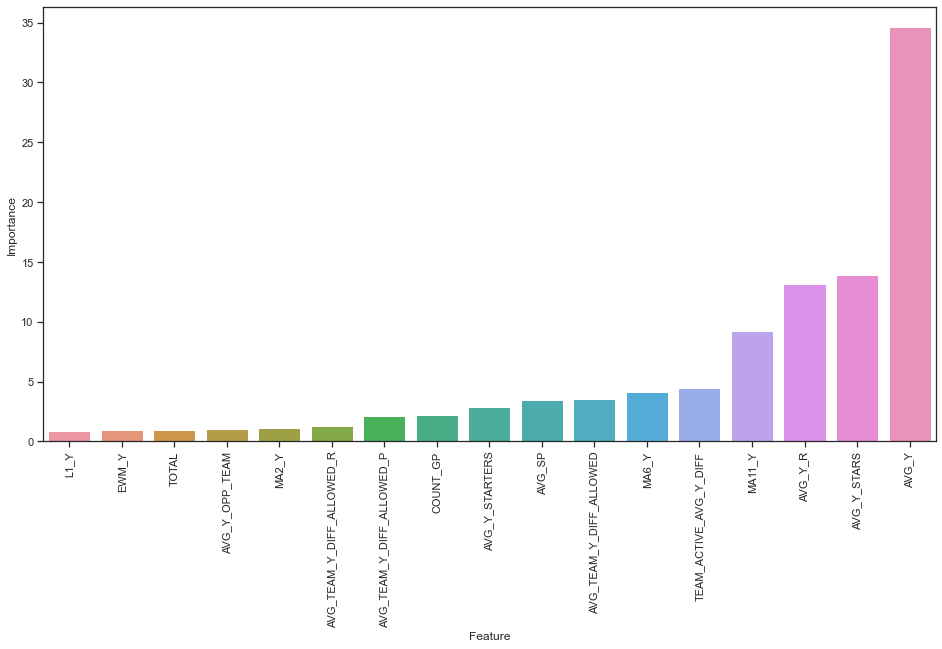

In [55]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [56]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.438
Baseline: 0.42

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.000813
Baseline: 0.00082

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.00107
Baseline: 0.001087


Residual analysis:

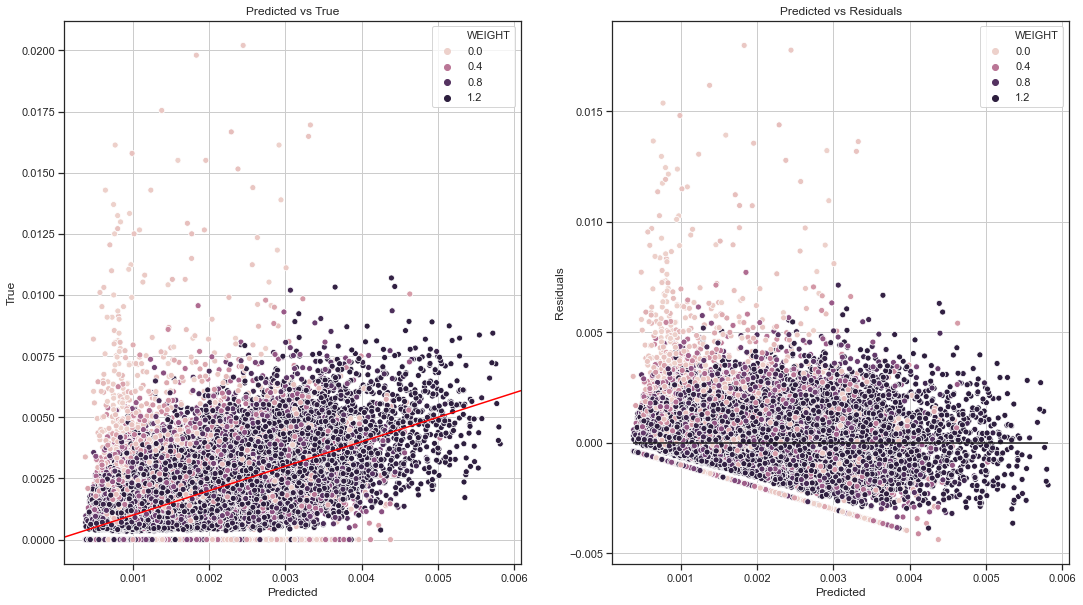

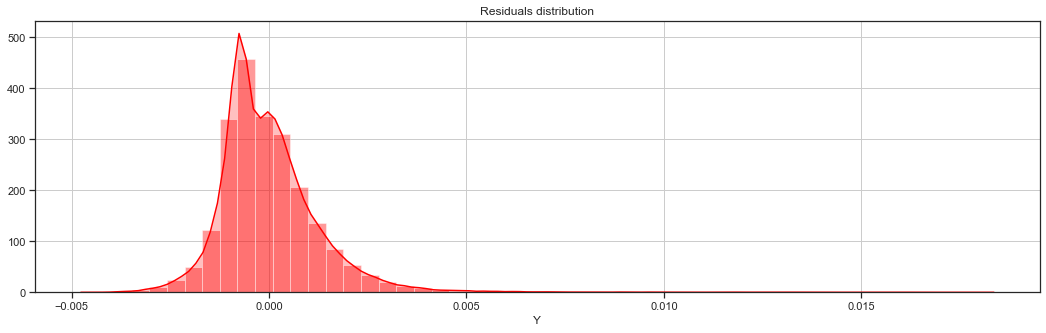

In [57]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [58]:
stat, p = shapiro(residuals)
print(stat, p)

0.8892480134963989 0.0


Residuals are normally distributed and not heteroskedastic.